In [1]:
from metamod.tasks import MultiTask, MNIST
from metamod.networks import NetworkSet, LinearNet
from metamod.trainers import set_network_training
from metamod.control import NetworkSetEq, LinearNetEq, NetworkSetControl
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

from metamod.utils import plot_lines, plot_weight_ev, check_dir, save_var, get_date_time
from bokeh.palettes import Viridis, Category10, Category20
from bokeh.plotting import figure, show, output_file, save
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from bokeh.io import export_svg
output_notebook()

Loading BokehJS ...

# I need to initialize every network in the maml class with the same set of weights

In [2]:
run_name = "deb_maml"
results_path = "../results"
results_dict = {}
n_steps = 1500
save_weights_every = 20
iter_control = 100
adam_lr = 0.005
control_lr = adam_lr

dataset_params1 = {"batch_size": 256,
                   "new_shape": (5, 5),
                   "subset": (0, 1)}
dataset_params2 = {"batch_size": 256,
                   "new_shape": (5, 5),
                   "subset": (7, 1)}
dataset_params3 = {"batch_size": 256,
                   "new_shape": (5, 5),
                   "subset": (8, 9)}
dataset_params = {"dataset_classes": (MNIST, MNIST, MNIST),
                  "dataset_list_params": (dataset_params1, dataset_params2, dataset_params3)}

dataset_class = MultiTask
optimize_test = False

network_params = {"learning_rate": 1e-3,
                  "hidden_dim": 40,
                  "intrinsic_noise": 0.0,
                  "reg_coef": 0.0,
                  "W1_0": None,
                  "W2_0": None}

network_class = LinearNet
network_copies = len(dataset_params["dataset_classes"])

model_params = {"network_class": network_class,
                "network_params": network_params,
                "n_copies": network_copies}

control_params = {"control_lower_bound": -1.0,
                  "control_upper_bound": 1.0,
                  "gamma": 0.99,
                  "cost_coef": 0,
                  "reward_convertion": 1.0,
                  "control_lr": control_lr}

In [3]:
dataset = dataset_class(**dataset_params)
model_params["network_params"]["input_dim"] = dataset.input_dim
model_params["network_params"]["output_dim"] = dataset.output_dim

# Init neural network
model = NetworkSet(**model_params)

/home/rodrigo/anaconda3/envs/metamod/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/rodrigo/anaconda3/envs/metamod/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/rodrigo/anaconda3/envs/metamod/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/rodrigo/anaconda3/envs/metamod/lib/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
iters, loss, test_loss, weights_iter, weights = set_network_training(model=model, dataset=dataset, n_steps=n_steps,
                                                                     save_weights_every=save_weights_every,
                                                                     return_test=True)

(0, 1)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 635.47it/s]


(7, 1)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 896.49it/s]


(8, 9)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 901.90it/s]


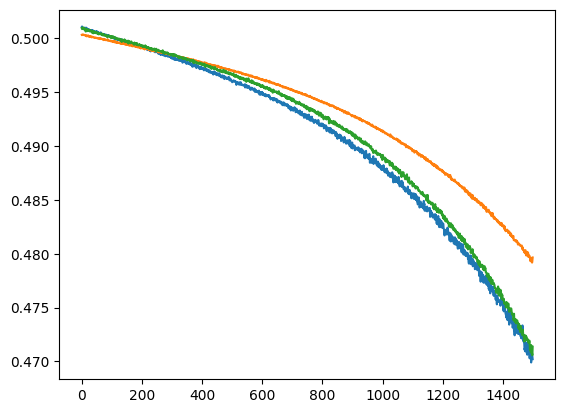

In [5]:
for i in range(3):
    plt.plot(loss[i, :], label = "set" + str(i))
plt.show()

In [6]:
results_dict["iters"] = iters
results_dict["Loss_t_sim"] = loss
results_dict["weights_sim"] = weights
results_dict["weights_iters_sim"] = weights_iter
results_dict["Loss_t_sim_test"] = test_loss
results_dict["avg_Loss_t_sim"] = np.mean(loss, axis=0)
results_dict["avg_Loss_t_sim_test"] = np.mean(test_loss, axis=0)

In [7]:
# Solving equation
init_W1 = weights[0][0, 0, ...]
init_W2 = weights[1][0, 0, ...]

init_weights = [init_W1, init_W2]
input_corr, output_corr, input_output_corr, expected_y, expected_x = dataset.get_correlation_matrix()
input_corr_test, output_corr_test, input_output_corr_test, expected_y_test, expected_x_test = dataset.get_correlation_matrix(
    training=False)

In [8]:
time_span = np.arange(0, len(iters)) * model_params["network_params"]["learning_rate"]
results_dict["time_span"] = time_span

In [9]:
equation_params = {"network_class": LinearNetEq,
                   "in_cov": input_corr,
                   "out_cov": output_corr,
                   "in_out_cov": input_output_corr,
                   "init_weights": init_weights,
                   "in_cov_test": input_corr_test,
                   "out_cov_test": output_corr_test,
                   "in_out_cov_test": input_output_corr_test,
                   "n_steps": n_steps,
                   "reg_coef": model_params["network_params"]["reg_coef"],
                   "intrinsic_noise": model_params["network_params"]["intrinsic_noise"],
                   "learning_rate": model_params["network_params"]["learning_rate"],
                   "time_constant": 1.0}

In [10]:
solver = NetworkSetEq(**equation_params)

W1_t, W2_t = solver.get_weights(time_span, get_numpy=True)
Loss_t = solver.get_loss_function(W1_t, W2_t, get_numpy=True)
Loss_t_test = solver.get_loss_function(W1_t, W2_t, get_numpy=True, use_test=True)

results_dict["W1_t_eq"] = W1_t
results_dict["W2_t_eq"] = W2_t
results_dict["Loss_t_eq"] = Loss_t
results_dict["Loss_t_eq_test"] = Loss_t_test

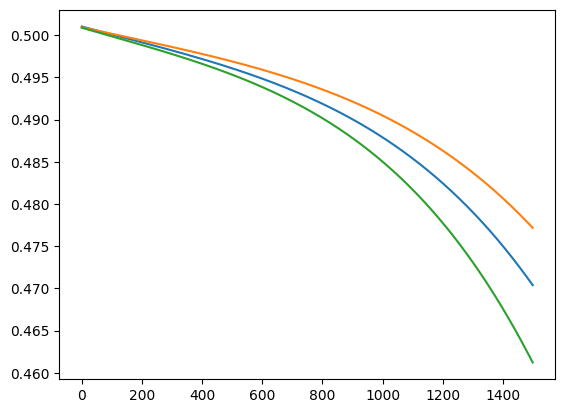

In [11]:
for i in range(3):
    plt.plot(Loss_t[i, :], label = "set" + str(i))
plt.show()

In [12]:
control_params = {**control_params, **copy.deepcopy(equation_params)}
control = NetworkSetControl(**control_params)

W1_t_control, W2_t_control = control.get_weights(time_span, get_numpy=True)
Loss_t_control = control.get_loss_function(W1_t_control, W2_t_control, get_numpy=True)
Loss_t_control_test = control.get_loss_function(W1_t, W2_t, get_numpy=True, use_test=True)

results_dict["W1_t_control_init"] = W1_t_control
results_dict["W2_t_control_init"] = W2_t_control
results_dict["Loss_t_control_init"] = Loss_t_control
results_dict["Loss_t_control_init_test"] = Loss_t_control_test
results_dict["control_signal_init"] = (control.W1_0, control.W2_0)


In [13]:
losses = [np.mean(loss, axis=0), np.mean(Loss_t, axis=0), np.mean(Loss_t_control, axis=0), 
          np.mean(Loss_t_test, axis=0), np.mean(Loss_t_control_test, axis=0)]
colors = (Category10[10][0], Category10[10][0], Category10[10][1], Category10[10][2], Category10[10][3])
legends = ("Simulation", "Equation", "Init Control", "Equation test", "Control test")
alphas = (0.3, 1, 1, 1, 1)

s = plot_lines(iters, losses, legends, alphas, colors)
show(s)

In [11]:
control_params["iters_control"] = iter_control
cumulated_reward = []
mean_grad = []

for i in tqdm(range(iter_control)):
    R, grad = control.train_step(get_numpy=True, eval_on_test=optimize_test)
    cumulated_reward.append(R)
    mean_grad.append(grad)
cumulated_reward = np.array(cumulated_reward).astype(float)
results_dict["cumulated_reward_opt"] = cumulated_reward

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.23it/s]
